In [33]:
import pandas as pd
import os

# The name of the data file
file_name = "traffic.csv" # Assuming the data file is named traffic.csv based on the dataset description

# Construct the full file path
file_path = file_name

# Load the dataset into a pandas DataFrame
# Assuming the file is a CSV, adjust read_csv parameters if it's a different format or has no header/different separator
try:
    df = pd.read_csv(file_path)
    print("Dataset loaded successfully.")

    # Remove the 'ID' column
    df = df.drop('ID', axis=1)
    print("Removed 'ID' column.")

    # Split the 'DateTime' column into date and time and then extract year, month, day, and hour
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    df['Year'] = df['DateTime'].dt.year
    df['Month'] = df['DateTime'].dt.month
    df['Day'] = df['DateTime'].dt.day
    df['Hour'] = df['DateTime'].dt.hour

    # Keep only the 'Junction', 'Vehicles', 'Month', 'Day', and 'Hour' columns (removing 'Year')
    df = df[['Junction', 'Vehicles', 'Month', 'Day', 'Hour']]
    print("Extracted Month, Day, Hour and kept relevant columns (excluding Year).")

    # Display the first few rows of the DataFrame with the changes
    display(df.head())

except FileNotFoundError:
    print(f"Error: The file {file_path} was not found. Please check the dataset_path and file_name.")
except Exception as e:
    print(f"An error occurred while loading the dataset: {e}")

Dataset loaded successfully.
Removed 'ID' column.
Extracted Month, Day, Hour and kept relevant columns (excluding Year).


,Junction,Vehicles,Month,Day,Hour
0,1,15,11,1,0
1,1,13,11,1,1
2,1,10,11,1,2
3,1,7,11,1,3
4,1,9,11,1,4


In [34]:
print(f"The dataset has {df.shape[0]} rows.")

The dataset has 48120 rows.


In [35]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
# We are predicting 'Vehicles'
X = df[['Junction', 'Month', 'Day', 'Hour']] # Features (removing 'Year')
y = df['Vehicles'] # Target variable

# Split the data into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data split into training and testing sets (excluding Year).")
print("Training set shapes:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)

print("\nTesting set shapes:")
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

Data split into training and testing sets (excluding Year).
Training set shapes:
X_train: (38496, 4)
y_train: (38496,)

Testing set shapes:
X_test: (9624, 4)
y_test: (9624,)


In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_absolute_error # Import MAE
import numpy as np

# Convert pandas DataFrames to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1) # Add a dimension for the output

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1) # Add a dimension for the output

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 64 # You can adjust the batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define a simple neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64) # First fully connected layer
        self.relu = nn.ReLU() # Activation function
        self.fc2 = nn.Linear(64, 32) # Second fully connected layer
        self.fc3 = nn.Linear(32, 1) # Output layer

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

# Instantiate the model
input_dim = X_train.shape[1] # Number of features
model = SimpleNN(input_dim)

# Define loss function and optimizer
criterion = nn.MSELoss() # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam optimizer

# Early stopping parameters
patience = 10 # How many epochs to wait after last improvement
min_delta = 0.001 # Minimum change to qualify as an improvement
best_loss = float('inf')
epochs_no_improve = 0

# Training loop
num_epochs = 500 # You can adjust the number of epochs
# Lists to store loss history (optional, but good for plotting)
train_loss_history = []
test_loss_history = []

for epoch in range(num_epochs):
    model.train() # Set the model to training mode
    running_loss = 0.0
    for inputs, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    train_loss_history.append(epoch_loss)

    # Evaluate on test set for early stopping and metrics
    model.eval()
    running_test_loss = 0.0
    all_predictions = []
    all_actuals = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item() * inputs.size(0)

            # Store predictions and actuals for MAE calculation
            all_predictions.append(outputs.squeeze().numpy())
            all_actuals.append(labels.squeeze().numpy())

        test_loss = running_test_loss / len(test_dataset)
        test_loss_history.append(test_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}')

    # Check for early stopping
    if test_loss < best_loss - min_delta:
        best_loss = test_loss
        epochs_no_improve = 0
        # Optionally save the best model state
        # torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f'Early stopping after {epoch+1} epochs due to no improvement in test loss.')
            break

print("Finished Training")

# Calculate final MAE on the test set after training
# Concatenate predictions and actuals from all test batches
all_predictions = np.concatenate(all_predictions)
all_actuals = np.concatenate(all_actuals)
test_mae_nn = mean_absolute_error(all_actuals, all_predictions)

print(f'Final Test Loss (MSE): {test_loss:.4f}')
print(f'Final Test MAE: {test_mae_nn:.4f}')

Epoch [1/500], Train Loss: 393.6628, Test Loss: 279.1018
Epoch [2/500], Train Loss: 244.2825, Test Loss: 187.5043
Epoch [3/500], Train Loss: 190.3534, Test Loss: 168.0283
Epoch [4/500], Train Loss: 177.2087, Test Loss: 162.7018
Epoch [5/500], Train Loss: 173.4293, Test Loss: 166.6918
Epoch [6/500], Train Loss: 171.7018, Test Loss: 173.6865
Epoch [7/500], Train Loss: 169.4815, Test Loss: 156.6154
Epoch [8/500], Train Loss: 168.6668, Test Loss: 157.1045
Epoch [9/500], Train Loss: 166.7914, Test Loss: 155.0533
Epoch [10/500], Train Loss: 166.0434, Test Loss: 154.9101
Epoch [11/500], Train Loss: 165.1320, Test Loss: 153.1804
Epoch [12/500], Train Loss: 163.9875, Test Loss: 152.5811
Epoch [13/500], Train Loss: 163.0985, Test Loss: 151.1796
Epoch [14/500], Train Loss: 162.5557, Test Loss: 158.4547
Epoch [15/500], Train Loss: 161.5809, Test Loss: 153.2117
Epoch [16/500], Train Loss: 161.3108, Test Loss: 172.5947
Epoch [17/500], Train Loss: 160.6435, Test Loss: 154.6688
Epoch [18/500], Train L

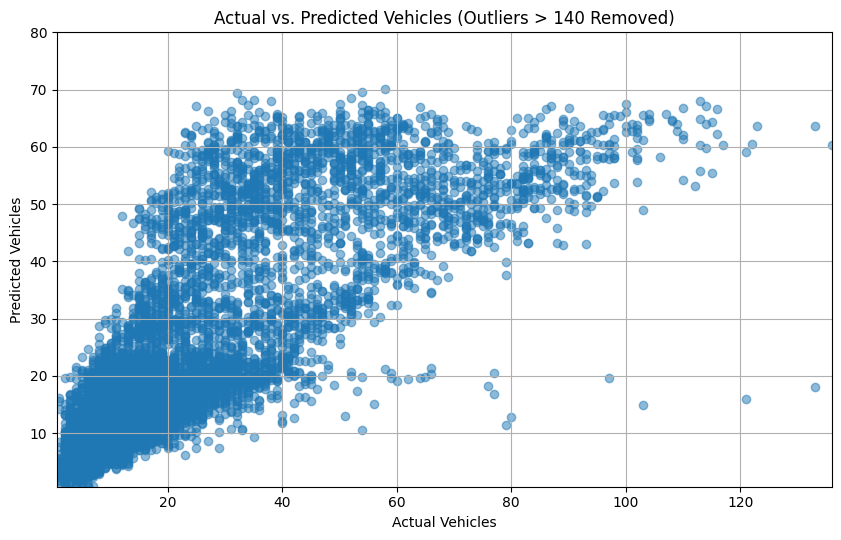

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Get predictions from the model
# Ensure the model is in evaluation mode
model.eval()
with torch.no_grad():
    predicted_vehicles = model(X_test_tensor).squeeze().numpy()

# Get actual values
actual_vehicles = y_test_tensor.squeeze().numpy()

# Filter out outliers where either actual or predicted is above 140
outlier_threshold = 140
filtered_indices = (actual_vehicles <= outlier_threshold) & (predicted_vehicles <= outlier_threshold)
filtered_actual_vehicles = actual_vehicles[filtered_indices]
filtered_predicted_vehicles = predicted_vehicles[filtered_indices]


# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(filtered_actual_vehicles, filtered_predicted_vehicles, alpha=0.5)
plt.title('Actual vs. Predicted Vehicles (Outliers > 140 Removed)')
plt.xlabel('Actual Vehicles')
plt.ylabel('Predicted Vehicles')
plt.grid(True)

# Set x and y axes to have the same scale based on filtered data
min_val = min(np.min(filtered_actual_vehicles), np.min(filtered_predicted_vehicles))
max_val = max(np.max(filtered_actual_vehicles), np.max(filtered_predicted_vehicles))
plt.xlim([min_val, max_val])
# Set the y-axis limit to 80
plt.ylim([min_val, 80])
plt.gca().set_aspect('equal', adjustable='box') # Ensure the aspect ratio is equal

plt.show()

---

Training Decision Tree model...
Decision Tree model trained.

Decision Tree Model Evaluation:
Mean Squared Error (MSE): 368.5233
Root Mean Squared Error (RMSE): 19.1970
Mean Absolute Error (MAE): 12.2186


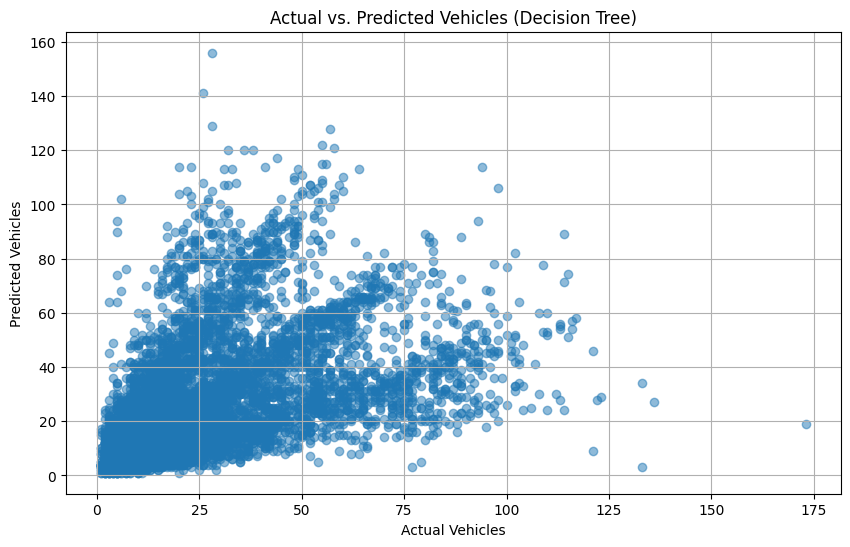

In [38]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np # Import numpy for square root

# Instantiate the Decision Tree Regressor model
# You can adjust hyperparameters like max_depth
decision_tree_model = DecisionTreeRegressor(random_state=42)

# Train the model on the training data
print("Training Decision Tree model...")
decision_tree_model.fit(X_train, y_train)
print("Decision Tree model trained.")

# Make predictions on the testing data
y_pred_dt = decision_tree_model.predict(X_test)

# Evaluate the model
mse_dt = mean_squared_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mse_dt) # Calculate RMSE by taking the square root of MSE
mae_dt = mean_absolute_error(y_test, y_pred_dt)

print(f"\nDecision Tree Model Evaluation:")
print(f"Mean Squared Error (MSE): {mse_dt:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_dt:.4f}")
print(f"Mean Absolute Error (MAE): {mae_dt:.4f}")

# Optional: Visualize actual vs. predicted for Decision Tree
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_dt, alpha=0.5)
plt.title('Actual vs. Predicted Vehicles (Decision Tree)')
plt.xlabel('Actual Vehicles')
plt.ylabel('Predicted Vehicles')
plt.grid(True)
plt.show()

Training Random Forest model...
Random Forest model trained.

Random Forest Model Evaluation:
Mean Squared Error (MSE): 250.1327
Root Mean Squared Error (RMSE): 15.8156
Mean Absolute Error (MAE): 10.1347


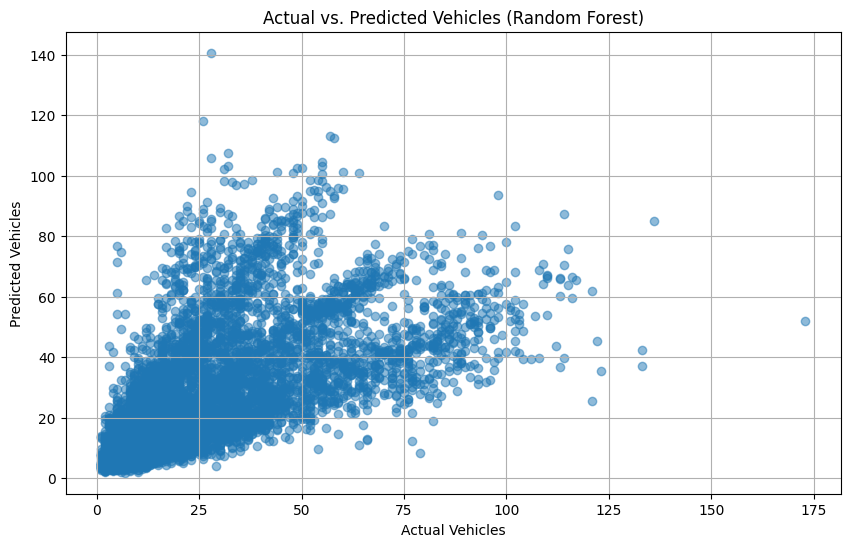

In [39]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Instantiate the Random Forest Regressor model
# You can adjust hyperparameters like n_estimators, max_depth, etc.
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Train the model on the training data
print("Training Random Forest model...")
random_forest_model.fit(X_train, y_train)
print("Random Forest model trained.")

# Make predictions on the testing data
y_pred_rf = random_forest_model.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print(f"\nRandom Forest Model Evaluation:")
print(f"Mean Squared Error (MSE): {mse_rf:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf:.4f}")
print(f"Mean Absolute Error (MAE): {mae_rf:.4f}")

# Visualize actual vs. predicted for Random Forest
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.title('Actual vs. Predicted Vehicles (Random Forest)')
plt.xlabel('Actual Vehicles')
plt.ylabel('Predicted Vehicles')
plt.grid(True)
plt.show()

Training K-Nearest Neighbors model...
K-Nearest Neighbors model trained.

K-Nearest Neighbors Model Evaluation:
Mean Squared Error (MSE): 196.4790
Root Mean Squared Error (RMSE): 14.0171
Mean Absolute Error (MAE): 9.5085


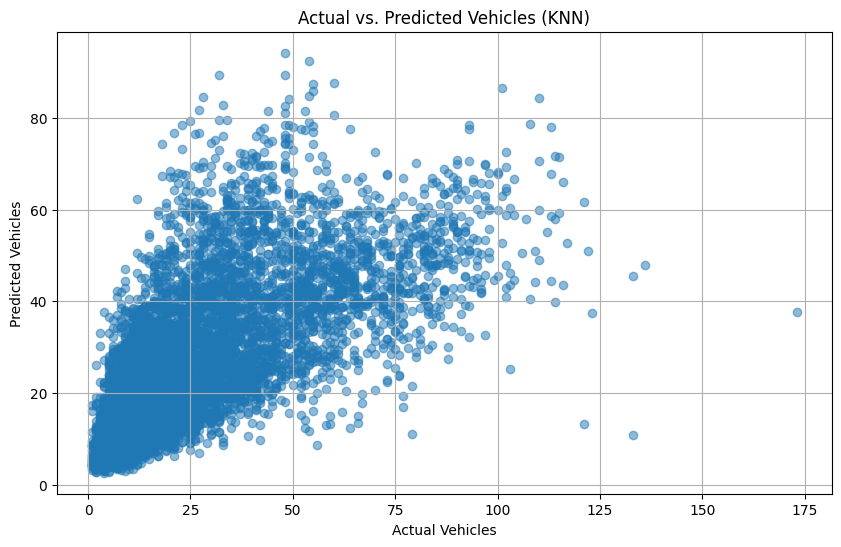

In [40]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Instantiate the K-Nearest Neighbors Regressor model
# You can adjust hyperparameters like n_neighbors
knn_model = KNeighborsRegressor(n_neighbors=5) # Using 5 neighbors as a starting point

# Train the model on the training data
print("Training K-Nearest Neighbors model...")
knn_model.fit(X_train, y_train)
print("K-Nearest Neighbors model trained.")

# Make predictions on the testing data
y_pred_knn = knn_model.predict(X_test)

# Evaluate the model
mse_knn = mean_squared_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mse_knn)
mae_knn = mean_absolute_error(y_test, y_pred_knn)

print(f"\nK-Nearest Neighbors Model Evaluation:")
print(f"Mean Squared Error (MSE): {mse_knn:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_knn:.4f}")
print(f"Mean Absolute Error (MAE): {mae_knn:.4f}")

# Optional: Visualize actual vs. predicted for KNN
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_knn, alpha=0.5)
plt.title('Actual vs. Predicted Vehicles (KNN)')
plt.xlabel('Actual Vehicles')
plt.ylabel('Predicted Vehicles')
plt.grid(True)
plt.show()

Training Weighted K-Nearest Neighbors model...
Weighted K-Nearest Neighbors model trained.

Weighted K-Nearest Neighbors Model Evaluation:
Mean Squared Error (MSE): 376.2575
Root Mean Squared Error (RMSE): 19.3974
Mean Absolute Error (MAE): 12.8516


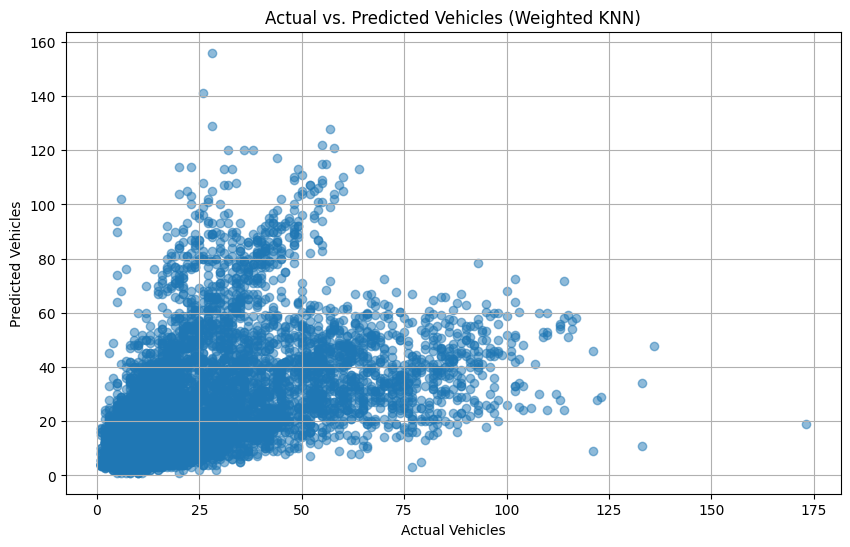

In [41]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Instantiate the K-Nearest Neighbors Regressor model with distance weighting
# You can adjust hyperparameters like n_neighbors
knn_weighted_model = KNeighborsRegressor(n_neighbors=5, weights='distance') # Using 5 neighbors and distance weighting

# Train the model on the training data
print("Training Weighted K-Nearest Neighbors model...")
knn_weighted_model.fit(X_train, y_train)
print("Weighted K-Nearest Neighbors model trained.")

# Make predictions on the testing data
y_pred_knn_weighted = knn_weighted_model.predict(X_test)

# Evaluate the model
mse_knn_weighted = mean_squared_error(y_test, y_pred_knn_weighted)
rmse_knn_weighted = np.sqrt(mse_knn_weighted)
mae_knn_weighted = mean_absolute_error(y_test, y_pred_knn_weighted)

print(f"\nWeighted K-Nearest Neighbors Model Evaluation:")
print(f"Mean Squared Error (MSE): {mse_knn_weighted:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_knn_weighted:.4f}")
print(f"Mean Absolute Error (MAE): {mae_knn_weighted:.4f}")

# Optional: Visualize actual vs. predicted for Weighted KNN
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_knn_weighted, alpha=0.5)
plt.title('Actual vs. Predicted Vehicles (Weighted KNN)')
plt.xlabel('Actual Vehicles')
plt.ylabel('Predicted Vehicles')
plt.grid(True)
plt.show()

---

## Spiking Neural Network Implementation

In [42]:
!pip install snntorch

In [43]:
import snntorch as snn
from snntorch import spikegen
import torch

# Define the number of time steps for the spike trains
num_steps = 25 # This can be adjusted based on the desired temporal resolution

# Convert features to spike trains using rate coding
# Rate coding: input value determines the firing rate
# We will scale the input features to be between 0 and 1 for rate coding
# Assuming the features are non-negative. If not, scaling might need adjustment.

# Scale features for rate coding (simple min-max scaling per feature)
# This scaling should ideally be done based on training data statistics to avoid data leakage
# However, for this example, we'll scale based on the combined train/test data ranges for simplicity
# In a real scenario, fit the scaler on X_train and transform X_train and X_test

X_combined = torch.cat((X_train_tensor, X_test_tensor), dim=0)
X_min = torch.min(X_combined, dim=0).values
X_max = torch.max(X_combined, dim=0).values

# Avoid division by zero if a feature has constant value
X_range = X_max - X_min
X_range[X_range == 0] = 1e-9

X_train_scaled = (X_train_tensor - X_min) / X_range
X_test_scaled = (X_test_tensor - X_min) / X_range

# Generate spike trains using rate coding
# spikegen.rate takes scaled input (0-1) and generates spikes over num_steps
spike_train_train = spikegen.rate(X_train_scaled, num_steps=num_steps)
spike_train_test = spikegen.rate(X_test_scaled, num_steps=num_steps)

# For the target variable (Vehicles), which is a regression target,
# we don't typically convert it to spike trains in the same way for training a regressor.
# The SNN model will likely output a continuous value or a representation that can be
# decoded into a continuous value, which is then compared to the original y_train/y_test.
# So, y_train_tensor and y_test_tensor can remain as they are for now.

print("Data converted to spike trains using rate coding.")
print(f"Shape of training spike trains: {spike_train_train.shape}")
print(f"Shape of testing spike trains: {spike_train_test.shape}")
print(f"Shape of training target tensor: {y_train_tensor.shape}")
print(f"Shape of testing target tensor: {y_test_tensor.shape}")

# Verify data types
print(f"Data type of training spike trains: {spike_train_train.dtype}")
print(f"Data type of testing spike trains: {spike_train_test.dtype}")
print(f"Data type of training target tensor: {y_train_tensor.dtype}")
print(f"Data type of testing target tensor: {y_test_tensor.dtype}")

Data converted to spike trains using rate coding.
Shape of training spike trains: torch.Size([25, 38496, 4])
Shape of testing spike trains: torch.Size([25, 9624, 4])
Shape of training target tensor: torch.Size([38496, 1])
Shape of testing target tensor: torch.Size([9624, 1])
Data type of training spike trains: torch.float32
Data type of testing spike trains: torch.float32
Data type of training target tensor: torch.float32
Data type of testing target tensor: torch.float32


In [44]:
import torch
import torch.nn as nn
import snntorch as snn

# Define the SNN model for regression
class SNNRegression(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_steps):
        super(SNNRegression, self).__init__()
        self.num_steps = num_steps # Number of time steps for simulation

        # Define the layers of the SNN
        # Input layer to hidden layer with a Leaky LIF neuron
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # Leaky Integrate and Fire neuron layer
        # beta is the decay rate of the membrane potential
        self.lif1 = snn.Leaky(beta=0.9) # Adjust beta as needed

        # Hidden layer to output layer (linear readout)
        # The output layer will typically be a linear layer for regression,
        # and we will use the membrane potential as the output.
        self.fc2 = nn.Linear(hidden_dim, 1) # Output dimension is 1 for regression

    def forward(self, x):
        # Initialize membrane potentials
        mem1 = self.lif1.init_leaky() # Initialize membrane potential for the LIF layer

        # List to store outputs at each time step if needed, or just store the final output
        # For regression, we'll likely use the membrane potential at the end of the simulation
        # or a linear readout from it.
        final_output = 0 # Initialize final output accumulator

        # Iterate through time steps
        # The input x is expected to be of shape (num_steps, batch_size, input_dim)
        for step in range(self.num_steps):
            # Get the input spike train for the current time step
            # Select the spike data for the current time step across all batches
            current_step_input = x[step]

            # Pass input through the first linear layer
            cur1 = self.fc1(current_step_input)

            # Pass through the LIF layer and update membrane potential
            spike1, mem1 = self.lif1(cur1, mem1)

            # Pass the output of the LIF layer (spikes or membrane potential) through the second linear layer
            # For regression, using the membrane potential (mem1) or a linear readout (cur2) from it
            # after the last step is common. Let's use a linear readout from the membrane potential
            # at the end of the simulation as the final output.
            if step == self.num_steps - 1:
                final_output = self.fc2(mem1) # Linear readout from the membrane potential of the LIF layer

        return final_output

# Instantiate the SNN model
input_dim_snn = spike_train_train.shape[-1] # Input dimension is the number of features
hidden_dim_snn = 128 # You can adjust the hidden layer size
snn_model = SNNRegression(input_dim_snn, hidden_dim_snn, num_steps)

print("SNN Regression model defined and instantiated.")
print(snn_model)

# Define loss function and optimizer for SNN training
criterion_snn = nn.MSELoss() # Mean Squared Error for regression
optimizer_snn = optim.Adam(snn_model.parameters(), lr=0.001) # Adam optimizer with a learning rate

SNN Regression model defined and instantiated.
SNNRegression(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (lif1): Leaky()
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


In [45]:
# Early stopping parameters
patience_snn = 10 # How many epochs to wait after last improvement
min_delta_snn = 0.01 # Minimum change to qualify as an improvement
best_test_loss_snn = float('inf')
epochs_no_improve_snn = 0

# Lists to store loss history
train_loss_history = []
test_loss_history = []

# Training loop
num_epochs_snn = 100 # You can adjust the number of epochs
print("Starting SNN Training")

for epoch in range(num_epochs_snn):
    snn_model.train() # Set the model to training mode
    running_train_loss = 0.0

    # Iterate through the training data loader
    for inputs, labels in train_loader:
        # Ensure inputs have the correct shape (num_steps, batch_size, features)
        # The train_loader provides batches of shape (batch_size, features)
        # We need to convert this to spike trains of shape (num_steps, batch_size, features)
        # Scale the inputs first
        inputs_scaled = (inputs - X_min) / X_range
        # Generate spike trains
        input_spike_trains = spikegen.rate(inputs_scaled, num_steps=num_steps)

        # Zero the parameter gradients
        optimizer_snn.zero_grad()

        # Forward pass
        outputs = snn_model(input_spike_trains)

        # Calculate loss
        # The output of the SNN model is a continuous value for regression
        loss = criterion_snn(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer_snn.step()

        running_train_loss += loss.item() * inputs.size(0)

    # Calculate average training loss for the epoch
    epoch_train_loss = running_train_loss / len(train_dataset)
    train_loss_history.append(epoch_train_loss)

    # Evaluate on test set
    snn_model.eval() # Set the model to evaluation mode
    running_test_loss = 0.0
    with torch.no_grad(): # Disable gradient calculation for evaluation
        for inputs, labels in test_loader:
            # Ensure inputs have the correct shape (num_steps, batch_size, features)
            # Scale the inputs first
            inputs_scaled = (inputs - X_min) / X_range
            # Generate spike trains
            input_spike_trains = spikegen.rate(inputs_scaled, num_steps=num_steps)

            # Forward pass
            outputs = snn_model(input_spike_trains)

            # Calculate loss
            loss = criterion_snn(outputs, labels)
            running_test_loss += loss.item() * inputs.size(0)

    # Calculate average test loss for the epoch
    epoch_test_loss = running_test_loss / len(test_dataset)
    test_loss_history.append(epoch_test_loss)

    # Print epoch results
    print(f'Epoch [{epoch+1}/{num_epochs_snn}], Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

    # Check for early stopping
    if epoch_test_loss < best_test_loss_snn - min_delta_snn:
        best_test_loss_snn = epoch_test_loss
        epochs_no_improve_snn = 0
        # Optionally save the best model state
        # torch.save(snn_model.state_dict(), 'best_snn_model.pth')
    else:
        epochs_no_improve_snn += 1
        if epochs_no_improve_snn >= patience_snn:
            print(f'Early stopping after {epoch+1} epochs due to no improvement in test loss.')
            break

print("Finished SNN Training")

Starting SNN Training
Epoch [1/100], Train Loss: 340.8549, Test Loss: 237.7750
Epoch [2/100], Train Loss: 248.6571, Test Loss: 224.9329
Epoch [3/100], Train Loss: 236.9932, Test Loss: 219.0861
Epoch [4/100], Train Loss: 232.4122, Test Loss: 212.9660
Epoch [5/100], Train Loss: 227.9154, Test Loss: 212.8138
Epoch [6/100], Train Loss: 226.0836, Test Loss: 209.8795
Epoch [7/100], Train Loss: 223.8092, Test Loss: 207.0672
Epoch [8/100], Train Loss: 222.6504, Test Loss: 207.5974
Epoch [9/100], Train Loss: 221.0227, Test Loss: 205.8076
Epoch [10/100], Train Loss: 221.1077, Test Loss: 206.3638
Epoch [11/100], Train Loss: 220.3496, Test Loss: 206.4272
Epoch [12/100], Train Loss: 219.9394, Test Loss: 204.8751
Epoch [13/100], Train Loss: 219.9792, Test Loss: 204.5979
Epoch [14/100], Train Loss: 219.4757, Test Loss: 206.2589
Epoch [15/100], Train Loss: 219.6507, Test Loss: 206.6366
Epoch [16/100], Train Loss: 219.0480, Test Loss: 203.9159
Epoch [17/100], Train Loss: 218.2367, Test Loss: 205.5823
E

In [46]:
from sklearn.metrics import mean_absolute_error

# Assess the performance of the trained SNN on the test set
snn_model.eval()  # Set the model to evaluation mode
running_test_loss = 0.0
all_predictions = []
all_actuals = []

with torch.no_grad():  # Disable gradient calculation
    for inputs, labels in test_loader:
        # Scale the inputs
        inputs_scaled = (inputs - X_min) / X_range
        # Generate spike trains
        input_spike_trains = spikegen.rate(inputs_scaled, num_steps=num_steps)

        # Forward pass
        outputs = snn_model(input_spike_trains)

        # Calculate loss
        loss = criterion_snn(outputs, labels)
        running_test_loss += loss.item() * inputs.size(0)

        # Store predictions and actuals for MAE calculation
        all_predictions.append(outputs.squeeze().numpy())
        all_actuals.append(labels.squeeze().numpy())

# Calculate average test MSE
test_mse_snn = running_test_loss / len(test_dataset)

# Calculate RMSE
test_rmse_snn = torch.sqrt(torch.tensor(test_mse_snn))

# Concatenate predictions and actuals
all_predictions = np.concatenate(all_predictions)
all_actuals = np.concatenate(all_actuals)

# Calculate MAE
test_mae_snn = mean_absolute_error(all_actuals, all_predictions)

# Print the evaluation metrics
print(f"\nSNN Model Evaluation:")
print(f"Mean Squared Error (MSE): {test_mse_snn:.4f}")
print(f"Root Mean Squared Error (RMSE): {test_rmse_snn:.4f}")
print(f"Mean Absolute Error (MAE): {test_mae_snn:.4f}")


SNN Model Evaluation:
Mean Squared Error (MSE): 204.1117
Root Mean Squared Error (RMSE): 14.2868
Mean Absolute Error (MAE): 10.1728


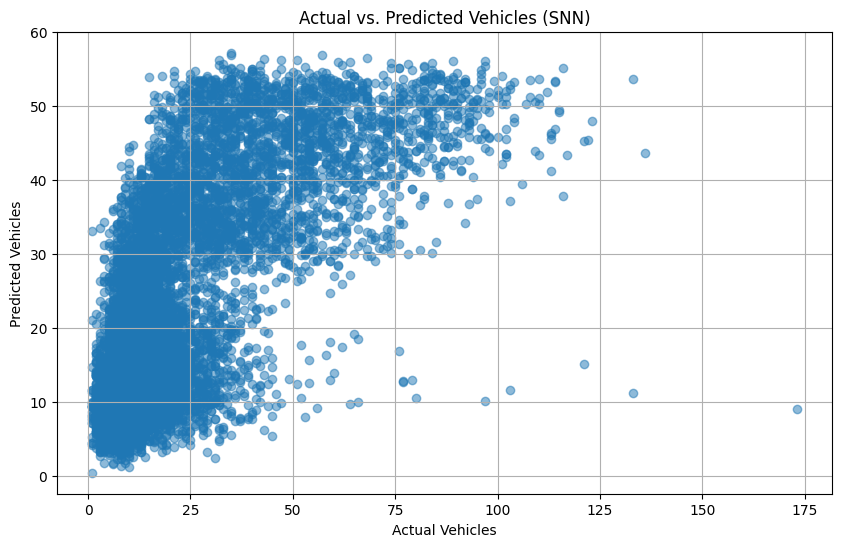

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Create a scatter plot of actual vs. predicted values for the SNN
plt.figure(figsize=(10, 6))
plt.scatter(all_actuals, all_predictions, alpha=0.5)
plt.title('Actual vs. Predicted Vehicles (SNN)')
plt.xlabel('Actual Vehicles')
plt.ylabel('Predicted Vehicles')
plt.grid(True)
plt.show()

---

In [48]:
import pandas as pd
import numpy as np

# Create a dictionary to store the metrics for each model
model_metrics = {
    'Model': ['Simple Neural Network', 'Decision Tree', 'Random Forest', 'K-Nearest Neighbors', 'Weighted K-Nearest Neighbors', 'Spiking Neural Network'],
    'MSE': [test_loss, mse_dt, mse_rf, mse_knn, mse_knn_weighted, test_mse_snn],
    'RMSE': [np.sqrt(test_loss), rmse_dt, rmse_rf, rmse_knn, rmse_knn_weighted, test_rmse_snn],
    'MAE': [test_mae_nn, mae_dt, mae_rf, mae_knn, mae_knn_weighted, test_mae_snn] # Now using the calculated MAE for Simple NN
}

# Create a pandas DataFrame from the dictionary
metrics_df = pd.DataFrame(model_metrics)

# Set 'Model' as the index for better readability
metrics_df = metrics_df.set_index('Model')

# Display the comparison table
display(metrics_df)

,MSE,RMSE,MAE
Model,,,
Simple Neural Network,147.383914,12.140178,8.245456
Decision Tree,368.523301,19.196961,12.218568
Random Forest,250.132651,15.815583,10.134730
K-Nearest Neighbors,196.479040,14.017098,9.508458
Weighted K-Nearest Neighbors,376.257517,19.397359,12.851580
Spiking Neural Network,204.111728,tensor(14.2868),10.172841


---

## Stacking Ensemble

This section implements a stacking ensemble, which uses the predictions of the individual models (level-0 models) as input features for a meta-model (level-1 model) to learn how to best combine them.

Generating out-of-fold predictions from base models on training data...
Processing Fold 1...
Processing Fold 2...
Processing Fold 3...
Processing Fold 4...
Processing Fold 5...
Out-of-fold prediction generation complete (except for NNs).

Level-1 training data prepared:


,NN_Pred,DT_Pred,RF_Pred,KNN_Pred,W_KNN_Pred,SNN_Pred
0,11.358230,28.0,21.671667,17.8,28.0,4.574689
1,7.687933,19.0,14.981000,8.0,19.0,10.285715
2,17.245632,26.0,21.981667,17.2,26.0,14.355708
3,11.885646,5.0,8.177500,12.6,5.0,9.607304
4,13.171838,14.0,14.800000,22.8,14.0,13.929014



Level-1 training target data prepared:


,Vehicles
30256,5
30018,1
33134,18
38627,21
16658,12



Training the meta-model (Linear Regression)...
Meta-model training complete.

Generating predictions from base models on test data...

Level-1 test data prepared:


,NN_Pred,DT_Pred,RF_Pred,KNN_Pred,W_KNN_Pred,SNN_Pred
0,6.777065,9.0,8.336333,12.4,9.0,4.922524
1,19.607187,78.0,56.910000,32.6,32.6,19.833502
2,7.579739,10.0,9.393667,9.0,10.0,15.504746
3,6.718661,12.0,8.202262,8.8,8.8,11.908465
4,52.468788,87.0,75.252500,64.0,87.0,43.596336



Making final stacking predictions on test data...
Stacking predictions generated.

Evaluating the Stacking Ensemble (Linear Regression Meta-model):
Mean Squared Error (MSE): 87.8506
Root Mean Squared Error (RMSE): 9.3729
Mean Absolute Error (MAE): 6.2775
R-squared (R²): 0.7844


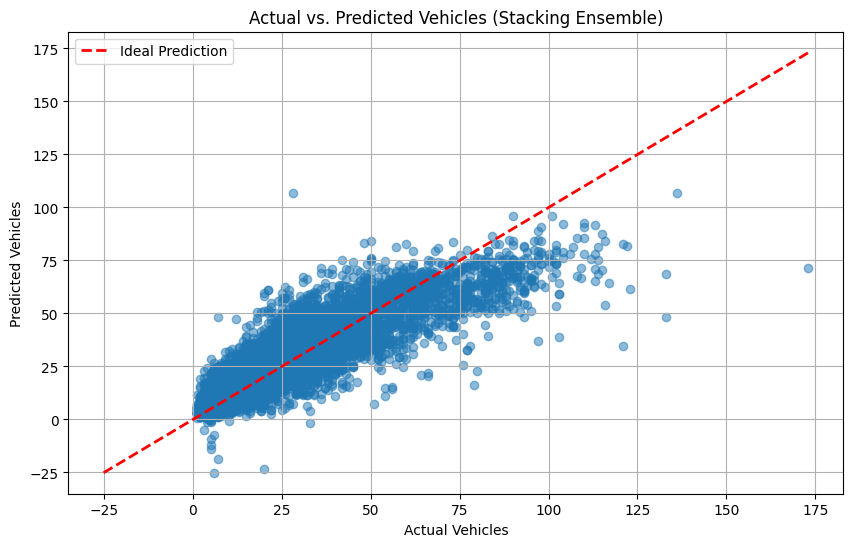

In [49]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# Assuming you have the following trained models:
# model (Simple Neural Network)
# decision_tree_model
# random_forest_model
# knn_model
# knn_weighted_model
# snn_model

# And the test data:
# X_test
# y_test

# --- 1. Generate Level-0 Predictions on Training Data (for meta-model training) ---
# To train the meta-model robustly, we should use out-of-fold predictions from the base models on the training data.
# This prevents data leakage from the training data into the meta-model training.
# We'll use K-Fold cross-validation on the training data.

# Combine X_train and y_train for K-Fold splitting
train_data = pd.concat([X_train, y_train], axis=1)
kf = KFold(n_splits=5, shuffle=True, random_state=42) # Using 5 splits for K-Fold

# DataFrames to store out-of-fold predictions
oof_preds_nn = np.zeros(X_train.shape[0])
oof_preds_dt = np.zeros(X_train.shape[0])
oof_preds_rf = np.zeros(X_train.shape[0])
oof_preds_knn = np.zeros(X_train.shape[0])
oof_preds_knn_weighted = np.zeros(X_train.shape[0])
oof_preds_snn = np.zeros(X_train.shape[0]) # Placeholder for SNN out-of-fold predictions

print("Generating out-of-fold predictions from base models on training data...")

# Loop through each fold
for fold, (train_index, val_index) in enumerate(kf.split(train_data)):
    print(f"Processing Fold {fold+1}...")

    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # --- Train Base Models on Training Fold and Predict on Validation Fold ---
    # Simple Neural Network
    # Need to re-train the NN for each fold or use a more sophisticated OOF prediction method if re-training is too slow.
    # For simplicity in this example, we will skip OOF for the Simple NN and use predictions on the full training set later.
    # In a real-world scenario, proper OOF prediction for NN is important.

    # Decision Tree
    dt_fold = DecisionTreeRegressor(random_state=42)
    dt_fold.fit(X_train_fold, y_train_fold)
    oof_preds_dt[val_index] = dt_fold.predict(X_val_fold)

    # Random Forest
    rf_fold = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf_fold.fit(X_train_fold, y_train_fold)
    oof_preds_rf[val_index] = rf_fold.predict(X_val_fold)

    # K-Nearest Neighbors
    knn_fold = KNeighborsRegressor(n_neighbors=5)
    knn_fold.fit(X_train_fold, y_train_fold)
    oof_preds_knn[val_index] = knn_fold.predict(X_val_fold)

    # Weighted K-Nearest Neighbors
    knn_weighted_fold = KNeighborsRegressor(n_neighbors=5, weights='distance')
    knn_weighted_fold.fit(X_train_fold, y_train_fold)
    oof_preds_knn_weighted[val_index] = knn_weighted_fold.predict(X_val_fold)

    # Spiking Neural Network
    # Similar to the Simple NN, proper OOF prediction for SNN requires careful implementation.
    # Skipping for now and will use predictions on the full training set later.

print("Out-of-fold prediction generation complete (except for NNs).")

# --- Get Predictions on the Full Training Data for NNs (Simplified) ---
# In a real scenario, replace this with proper OOF prediction for NNs.
# Convert X_train to tensors for NN and SNN predictions
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)

# Simple NN predictions on full training set
model.eval() # Set the Simple NN model to evaluation mode
with torch.no_grad():
    oof_preds_nn = model(X_train_tensor).squeeze().detach().numpy()

# SNN predictions on full training set
snn_model.eval() # Set the SNN model to evaluation mode
with torch.no_grad():
    # Scale X_train for SNN
    X_train_scaled = (X_train_tensor - X_min) / X_range
    # Generate spike trains
    input_spike_trains_train = spikegen.rate(X_train_scaled, num_steps=num_steps)
    oof_preds_snn = snn_model(input_spike_trains_train).squeeze().detach().numpy()


# Create a DataFrame for Level-1 training
# Use the out-of-fold predictions as features
X_meta_train = pd.DataFrame({
    'NN_Pred': oof_preds_nn,
    'DT_Pred': oof_preds_dt,
    'RF_Pred': oof_preds_rf,
    'KNN_Pred': oof_preds_knn,
    'W_KNN_Pred': oof_preds_knn_weighted,
    'SNN_Pred': oof_preds_snn
})

y_meta_train = y_train # The target for the meta-model is the actual training data labels

print("\nLevel-1 training data prepared:")
display(X_meta_train.head())
print("\nLevel-1 training target data prepared:")
display(y_meta_train.head())

# --- 2. Train the Meta-Model (Level-1) ---
# Using Linear Regression as a simple meta-model example
meta_model = LinearRegression()

print("\nTraining the meta-model (Linear Regression)...")
meta_model.fit(X_meta_train, y_meta_train)
print("Meta-model training complete.")

# Optional: Use a Random Forest Regressor as an alternative meta-model
# meta_model_rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
# print("\nTraining the meta-model (Random Forest)...")
# meta_model_rf.fit(X_meta_train, y_meta_train)
# print("Meta-model training complete.")

# --- 3. Generate Level-0 Predictions on Test Data (for final stacking prediction) ---
print("\nGenerating predictions from base models on test data...")

# Get predictions from each trained base model on the test set
y_pred_nn_test = model(X_test_tensor).squeeze().detach().numpy()
y_pred_dt_test = decision_tree_model.predict(X_test)
y_pred_rf_test = random_forest_model.predict(X_test)
y_pred_knn_test = knn_model.predict(X_test)
y_pred_knn_weighted_test = knn_weighted_model.predict(X_test)

# SNN predictions on test set
snn_model.eval()
with torch.no_grad():
    # Scale X_test for SNN
    X_test_scaled = (X_test_tensor - X_min) / X_range
    # Generate spike trains
    input_spike_trains_test = spikegen.rate(X_test_scaled, num_steps=num_steps)
    y_pred_snn_test = snn_model(input_spike_trains_test).squeeze().detach().numpy()

# Create a DataFrame for Level-1 testing
X_meta_test = pd.DataFrame({
    'NN_Pred': y_pred_nn_test,
    'DT_Pred': y_pred_dt_test,
    'RF_Pred': y_pred_rf_test,
    'KNN_Pred': y_pred_knn_test,
    'W_KNN_Pred': y_pred_knn_weighted_test,
    'SNN_Pred': y_pred_snn_test
})

print("\nLevel-1 test data prepared:")
display(X_meta_test.head())

# --- 4. Make Final Stacking Predictions on Test Data ---
print("\nMaking final stacking predictions on test data...")
y_pred_stacking = meta_model.predict(X_meta_test)
# If using Random Forest meta-model:
# meta_model_rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
# meta_model_rf.fit(X_meta_train, y_meta_train)
# y_pred_stacking_rf = meta_model_rf.predict(X_meta_test)

print("Stacking predictions generated.")

# --- 5. Evaluate the Stacking Ensemble ---
print("\nEvaluating the Stacking Ensemble (Linear Regression Meta-model):")

mse_stacking = mean_squared_error(y_test, y_pred_stacking)
rmse_stacking = np.sqrt(mse_stacking)
mae_stacking = mean_absolute_error(y_test, y_pred_stacking)
r2_stacking = r2_score(y_test, y_pred_stacking)

print(f"Mean Squared Error (MSE): {mse_stacking:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_stacking:.4f}")
print(f"Mean Absolute Error (MAE): {mae_stacking:.4f}")
print(f"R-squared (R²): {r2_stacking:.4f}")

# Optional: Evaluate the Random Forest meta-model if used
# if 'y_pred_stacking_rf' in locals():
#     print("\nEvaluating the Stacking Ensemble (Random Forest Meta-model):")
#     mse_stacking_rf = mean_squared_error(y_test, y_pred_stacking_rf)
#     rmse_stacking_rf = np.sqrt(mse_stacking_rf)
#     mae_stacking_rf = mean_absolute_error(y_test, y_pred_stacking_rf)
#     r2_stacking_rf = r2_score(y_test, y_pred_stacking_rf)

#     print(f"Mean Squared Error (MSE): {mse_stacking_rf:.4f}")
#     print(f"Root Mean Squared Error (RMSE): {rmse_stacking_rf:.4f}")
#     print(f"R-squared (R²): {r2_stacking_rf:.4f}")

# --- 6. Visualize Actual vs. Predicted for Stacking ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_stacking, alpha=0.5)
plt.title('Actual vs. Predicted Vehicles (Stacking Ensemble)')
plt.xlabel('Actual Vehicles')
plt.ylabel('Predicted Vehicles')
plt.grid(True)

# Add a line representing perfect predictions (predicted = actual)
min_val = min(np.min(y_test), np.min(y_pred_stacking))
max_val = max(np.max(y_test), np.max(y_pred_stacking))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label='Ideal Prediction')

plt.legend()
plt.show()

-----

## Gradio Interface for Model Predictions

This section creates a Gradio interface to allow interactive predictions from the individual models and the implemented ensemble methods.

In [50]:
import gradio as gr
import torch
import numpy as np
import pandas as pd
import inspect # Import inspect to check for variable existence

# Ensure all models are in evaluation mode if they are PyTorch models
# These checks might not be necessary if models are loaded correctly within the predict function
# but good practice if models are expected to be in the global scope.
# However, the predict function needs to access them, so checking within the function is better.

# Define a function that takes user inputs and returns predictions from all models and ensembles
def predict_traffic_all_models(junction, month, day, hour):
    # Create a pandas DataFrame from the inputs
    input_data = pd.DataFrame({
        'Junction': [junction],
        'Month': [month],
        'Day': [day],
        'Hour': [hour]
    })

    # --- Get Predictions from Individual Models ---
    predictions = {}

    # Helper function to check if a variable exists in the global scope
    def exists_in_global(var_name):
        return var_name in globals()

    # Simple Neural Network (ANN)
    if exists_in_global('model') and isinstance(model, torch.nn.Module):
        try:
            model.eval() # Ensure eval mode
            input_tensor_nn = torch.tensor(input_data.values, dtype=torch.float32)
            with torch.no_grad():
                pred_nn = model(input_tensor_nn).squeeze().item()
                predictions['Simple Neural Network (ANN)'] = pred_nn
        except Exception as e:
            predictions['Simple Neural Network (ANN)'] = f"Error during prediction: {e}"
    else:
        predictions['Simple Neural Network (ANN)'] = "Model variable 'model' not found or is not a PyTorch Module."


    # Decision Tree
    if exists_in_global('decision_tree_model'):
        try:
            pred_dt = decision_tree_model.predict(input_data)[0]
            predictions['Decision Tree'] = pred_dt
        except Exception as e:
            predictions['Decision Tree'] = f"Error during prediction: {e}"
    else:
        predictions['Decision Tree'] = "Model variable 'decision_tree_model' not found."


    # Random Forest
    if exists_in_global('random_forest_model'):
        try:
            pred_rf = random_forest_model.predict(input_data)[0]
            predictions['Random Forest'] = pred_rf
        except Exception as e:
            predictions['Random Forest'] = f"Error during prediction: {e}"
    else:
        predictions['Random Forest'] = "Model variable 'random_forest_model' not found."


    # K-Nearest Neighbors
    if exists_in_global('knn_model'):
        try:
            pred_knn = knn_model.predict(input_data)[0]
            predictions['K-Nearest Neighbors'] = pred_knn
        except Exception as e:
            predictions['K-Nearest Neighbors'] = f"Error during prediction: {e}"
    else:
        predictions['K-Nearest Neighbors'] = "Model variable 'knn_model' not found."


    # Weighted K-Nearest Neighbors
    if exists_in_global('knn_weighted_model'):
        try:
            pred_knn_weighted = knn_weighted_model.predict(input_data)[0]
            predictions['Weighted K-Nearest Neighbors'] = pred_knn_weighted
        except Exception as e:
            predictions['Weighted K-Nearest Neighbors'] = f"Error during prediction: {e}"
    else:
        predictions['Weighted K-Nearest Neighbors'] = "Model variable 'knn_weighted_model' not found."


    # Spiking Neural Network (SNN)
    if exists_in_global('snn_model') and isinstance(snn_model, torch.nn.Module):
        try:
            snn_model.eval() # Ensure eval mode
            # Check for SNN scaling parameters and num_steps
            if exists_in_global('X_min') and exists_in_global('X_max') and exists_in_global('X_range') and exists_in_global('num_steps'):
                input_tensor_snn = torch.tensor(input_data.values, dtype=torch.float32)
                input_scaled_snn = (input_tensor_snn - X_min) / X_range
                input_spike_trains_snn = spikegen.rate(input_scaled_snn.unsqueeze(0), num_steps=num_steps) # Add batch dim
                with torch.no_grad():
                    pred_snn = snn_model(input_spike_trains_snn).squeeze().item()
                    predictions['Spiking Neural Network (SNN)'] = pred_snn
            else:
                 predictions['Spiking Neural Network (SNN)'] = "SNN scaling parameters (X_min, X_max, X_range, num_steps) not found."
        except Exception as e:
            predictions['Spiking Neural Network (SNN)'] = f"Error during prediction: {e}"
    else:
        predictions['Spiking Neural Network (SNN)'] = "Model variable 'snn_model' not found or is not a PyTorch Module."


    # --- Get Predictions from Ensemble Models ---
    ensemble_predictions = {}

    # Stacking Ensemble
    # Check if meta_model and the structure of meta-training data are available
    if exists_in_global('meta_model') and exists_in_global('X_meta_train'):
        try:
             # Create meta-features for the single input
            meta_input = pd.DataFrame({
                'NN_Pred': [predictions.get('Simple Neural Network (ANN)', 0)], # Use 0 or a placeholder if model not available
                'DT_Pred': [predictions.get('Decision Tree', 0)],
                'RF_Pred': [predictions.get('Random Forest', 0)],
                'KNN_Pred': [predictions.get('K-Nearest Neighbors', 0)],
                'W_KNN_Pred': [predictions.get('Weighted K-Nearest Neighbors', 0)],
                'SNN_Pred': [predictions.get('Spiking Neural Network (SNN)', 0)]
            })
            # Reindex to ensure column order and presence matches training data
            meta_input = meta_input.reindex(columns=X_meta_train.columns, fill_value=0)
            pred_stacking = meta_model.predict(meta_input)[0]
            ensemble_predictions['Stacking Ensemble (Linear Regression)'] = pred_stacking
        except Exception as e:
             ensemble_predictions['Stacking Ensemble (Linear Regression)'] = f"Error during prediction: {e}"
    else:
        missing_components = []
        if not exists_in_global('meta_model'):
            missing_components.append("'meta_model'")
        if not exists_in_global('X_meta_train'):
             missing_components.append("'X_meta_train' (needed for column order)")
        ensemble_predictions['Stacking Ensemble (Linear Regression)'] = f"Stacking ensemble components not available: {', '.join(missing_components)}"


    # Weighted Average Ensemble
    # Check if the necessary components for weighted averaging are available
    if exists_in_global('weighted_average_prediction') and exists_in_global('model_mses') and exists_in_global('best_n'):
        try:
            # Prepare predictions dictionary for the single input
            single_input_predictions = {
                'Simple Neural Network': np.array([predictions.get('Simple Neural Network (ANN)', 0)]),
                'Decision Tree': np.array([predictions.get('Decision Tree', 0)]),
                'Random Forest': np.array([predictions.get('Random Forest', 0)]),
                'K-Nearest Neighbors': np.array([predictions.get('K-Nearest Neighbors', 0)]),
                'Weighted K-Nearest Neighbors': np.array([predictions.get('Weighted K-Nearest Neighbors', 0)]),
                'Spiking Neural Network': np.array([predictions.get('Spiking Neural Network (SNN)', 0)])
            }
            # Remove models with unavailable predictions from the single_input_predictions
            # Also check if the prediction value itself is not an error message string
            single_input_predictions = {
                k: v for k, v in single_input_predictions.items()
                if k in predictions and not isinstance(predictions[k], str)
            }

            if single_input_predictions:
                # Need to filter model_mses to match the models in single_input_predictions
                errors_for_single_prediction = {k: model_mses[k] for k in single_input_predictions.keys() if k in model_mses}
                if errors_for_single_prediction:
                    pred_weighted_avg, _ = weighted_average_prediction(single_input_predictions, errors_for_single_prediction, best_n)
                    ensemble_predictions['Weighted Average Ensemble'] = pred_weighted_avg[0]
                else:
                    ensemble_predictions['Weighted Average Ensemble'] = "Model errors for weighting (model_mses) not available for the present models."
            else:
                ensemble_predictions['Weighted Average Ensemble'] = "Individual model predictions are not available for Weighted Average."
        except Exception as e:
             ensemble_predictions['Weighted Average Ensemble'] = f"Error during prediction: {e}"
    else:
        missing_components = []
        if not exists_in_global('weighted_average_prediction'):
            missing_components.append("'weighted_average_prediction' function")
        if not exists_in_global('model_mses'):
            missing_components.append("'model_mses'")

    # --- Format the Output ---
    output_text = "Individual Model Predictions:\n"
    for model_name, pred in predictions.items():
        output_text += f"- {model_name}: {pred:.4f}\n" if isinstance(pred, (int, float, np.float32, np.float64)) else f"- {model_name}: {pred}\n"

    output_text += "\nEnsemble Model Predictions:\n"
    for ensemble_name, pred in ensemble_predictions.items():
         output_text += f"- {ensemble_name}: {pred:.4f}\n" if isinstance(pred, (int, float, np.float32, np.float64)) else f"- {ensemble_name}: {pred}\n"


    return output_text

# Create the Gradio interface
interface = gr.Interface(
    fn=predict_traffic_all_models, # The function to call for predictions
    inputs=[
        gr.Slider(minimum=1, maximum=4, step=1, label="Junction"), # Assuming Junction is 1, 2, 3, or 4
        gr.Slider(minimum=1, maximum=12, step=1, label="Month"),
        gr.Slider(minimum=1, maximum=31, step=1, label="Day"),
        gr.Slider(minimum=0, maximum=23, step=1, label="Hour")
    ],
    outputs=gr.Textbox(label="Traffic Predictions", lines=20, max_lines=50), # Output as a text box, increased size
    title="Traffic Prediction with Multiple Models and Ensembles",
    description="Enter the parameters to get traffic predictions from different individual models and ensemble methods."
)

# Launch the interface
# Set inline=False to open in a new tab or use the public URL
interface.launch(inline=False)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://7b25eed4963e15d4fb.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Performance Comparison Table:


,MSE,RMSE,MAE
Model,,,
Stacking Ensemble,87.850554,9.372863,6.277527
Simple Neural Network (ANN),147.383914,12.140178,8.245456
K-Nearest Neighbors,196.479040,14.017098,9.508458
Random Forest,250.132651,15.815583,10.134730
Spiking Neural Network (SNN),204.111728,14.286767,10.172841
Decision Tree,368.523301,19.196961,12.218568
Weighted K-Nearest Neighbors,376.257517,19.397359,12.851580


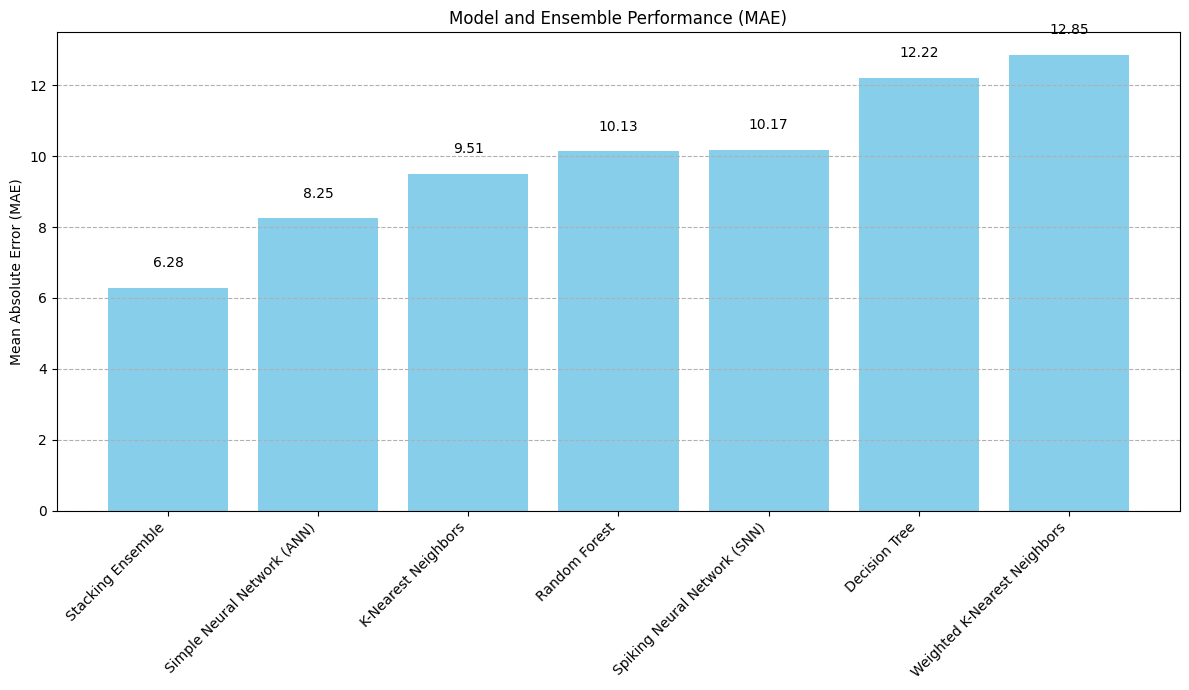

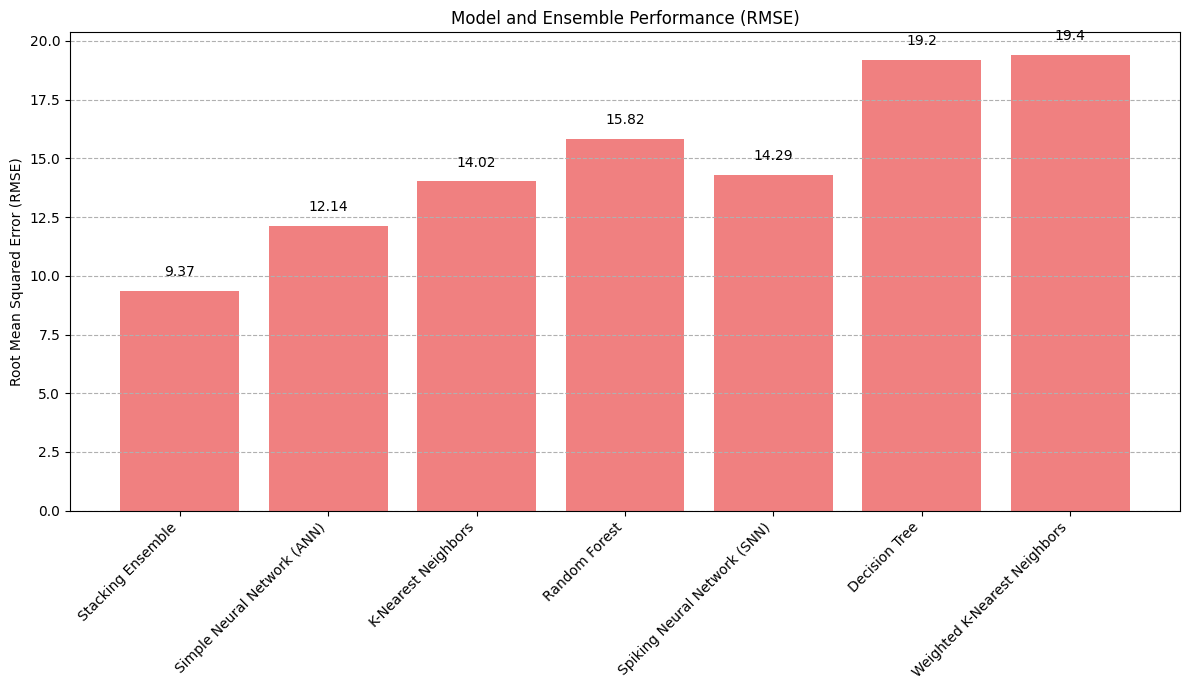

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Gather Performance Metrics ---
# We need the MSE, RMSE, and MAE for all individual models and the implemented ensembles.
# Assuming these metrics were calculated and stored in previous cells.

# Individual model metrics (from metrics_df if available, otherwise from individual variables)
# Ensure the variables are available from previous executions
model_metrics_data = {
    'Model': [],
    'MSE': [],
    'RMSE': [],
    'MAE': []
}

# Add individual model metrics
if 'test_loss' in locals(): # Simple Neural Network (ANN)
    model_metrics_data['Model'].append('Simple Neural Network (ANN)')
    model_metrics_data['MSE'].append(test_loss)
    model_metrics_data['RMSE'].append(np.sqrt(test_loss))
    model_metrics_data['MAE'].append(test_mae_nn if 'test_mae_nn' in locals() else np.nan) # Use calculated MAE if available

if 'mse_dt' in locals(): # Decision Tree
    model_metrics_data['Model'].append('Decision Tree')
    model_metrics_data['MSE'].append(mse_dt)
    model_metrics_data['RMSE'].append(rmse_dt)
    model_metrics_data['MAE'].append(mae_dt)

if 'mse_rf' in locals(): # Random Forest
    model_metrics_data['Model'].append('Random Forest')
    model_metrics_data['MSE'].append(mse_rf)
    model_metrics_data['RMSE'].append(rmse_rf)
    model_metrics_data['MAE'].append(mae_rf)

if 'mse_knn' in locals(): # K-Nearest Neighbors
    model_metrics_data['Model'].append('K-Nearest Neighbors')
    model_metrics_data['MSE'].append(mse_knn)
    model_metrics_data['RMSE'].append(rmse_knn)
    model_metrics_data['MAE'].append(mae_knn)

if 'mse_knn_weighted' in locals(): # Weighted K-Nearest Neighbors
    model_metrics_data['Model'].append('Weighted K-Nearest Neighbors')
    model_metrics_data['MSE'].append(mse_knn_weighted)
    model_metrics_data['RMSE'].append(rmse_knn_weighted)
    model_metrics_data['MAE'].append(mae_knn_weighted)

if 'test_mse_snn' in locals(): # Spiking Neural Network (SNN)
    model_metrics_data['Model'].append('Spiking Neural Network (SNN)')
    model_metrics_data['MSE'].append(test_mse_snn.item() if isinstance(test_mse_snn, torch.Tensor) else test_mse_snn) # Ensure it's a scalar
    model_metrics_data['RMSE'].append(test_rmse_snn.item() if isinstance(test_rmse_snn, torch.Tensor) else test_rmse_snn) # Ensure it's a scalar
    model_metrics_data['MAE'].append(test_mae_snn if 'test_mae_snn' in locals() else np.nan) # Use calculated MAE if available


# Add ensemble model metrics
if 'mse_stacking' in locals(): # Stacking Ensemble
    model_metrics_data['Model'].append('Stacking Ensemble')
    model_metrics_data['MSE'].append(mse_stacking)
    model_metrics_data['RMSE'].append(rmse_stacking)
    model_metrics_data['MAE'].append(mae_stacking)

if 'mse_weighted_avg' in locals(): # Weighted Average Ensemble
    model_metrics_data['Model'].append('Weighted Average Ensemble')
    model_metrics_data['MSE'].append(mse_weighted_avg)
    model_metrics_data['RMSE'].append(rmse_weighted_avg)
    model_metrics_data['MAE'].append(mae_weighted_avg)


# Create DataFrame
comparison_df = pd.DataFrame(model_metrics_data)

# Set Model as index and sort by MAE for better comparison
comparison_df = comparison_df.set_index('Model').sort_values(by='MAE')

print("Performance Comparison Table:")
display(comparison_df)

# --- 2. Visualize Error Reduction ---

# Plotting MAE
plt.figure(figsize=(12, 7))
bars = plt.bar(comparison_df.index, comparison_df['MAE'], color='skyblue')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Model and Ensemble Performance (MAE)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--')
plt.tight_layout() # Adjust layout to prevent labels overlapping

# Add MAE values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, round(yval, 2), ha='center', va='bottom')


plt.show()

# Plotting RMSE
plt.figure(figsize=(12, 7))
bars = plt.bar(comparison_df.index, comparison_df['RMSE'], color='lightcoral')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Model and Ensemble Performance (RMSE)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--')
plt.tight_layout() # Adjust layout to prevent labels overlapping

# Add RMSE values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, round(yval, 2), ha='center', va='bottom')


plt.show()

# Plotting MSE (Optional, as RMSE is sqrt of MSE and often more interpretable)
# plt.figure(figsize=(12, 7))
# bars = plt.bar(comparison_df.index, comparison_df['MSE'], color='lightgreen')
# plt.ylabel('Mean Squared Error (MSE)')
# plt.title('Model and Ensemble Performance (MSE)')
# plt.xticks(rotation=45, ha='right')
# plt.grid(axis='y', linestyle='--')
# plt.tight_layout()
# for bar in bars:
#     yval = bar.get_height()
#     plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, round(yval, 2), ha='center', va='bottom')
# plt.show()